###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2021 Lorena A. Barba, Pi-Yueh Chuang

# Multiple logistic regression

This is the fifth lesson of our module on _deep learning_, and it's perhpas surprising that we still are discussing linear models! Our approach is to build up to our final goal in an incremental fashion. 
We have thus stayed in the more accessible setting of linear models while introducing key ingredients: gradient descent for optimization; automatic differentiation; multi-dimensional input variables (features); normalization (feature scaling); underfitting/overfitting and regularization. You've come a long way!

In this lesson, we want to give you a taste of more practical machine learning applications. We are going to use _multiple logistic regression_ (meaning, we have multiple features) for the problem of identifying defective metal-casting parts: a classification problem. Let's begin. 

First, let's import modules that we'll need later:

In [1]:
from autograd import numpy
from autograd import grad
from matplotlib import pyplot

With the `numpy` submodule from `autograd`, instead of regular `numpy`, we can get automatic differentiation with the `grad` function. 
This is where `autograd` keeps track of and applies the differentiation rules to NumPy functions. The only requirement is that we define Python _functions_ for the code portions we would like derivatives of. 

## Images of metal-casting parts

In automated manufacturing, it's common to check the quality of products using computer vision. After taking a picture of a product, a machine learning model identifies if this product has defects or not. This lesson will use a multiple logistic regression model to identify defective metal-casting parts from pictures.

The source of the images of casting parts is in Reference [1]. To make the dataset smaller for this teaching material, we converted the images to grayscale and reduced the resolutions and the number of images. (With the original data, the training would take too long to run on a laptop.) We also transformed the data to `numpy` compressed array format (extension `.npz`). This file format is useful for saving several arrays together in one file. 
Read about it in the [`numpy.savez()`](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) documentation page.

Run the code below to load the image data. If you don't have the data locally, you can download it from this short URL: https://go.gwu.edu/engcomp6data5 — be sure to edit the path below, in that case. And do to read the documentation page for [`numpy.load()`](https://numpy.org/doc/stable/reference/generated/numpy.load.html#numpy.load) if you need to.

In [2]:
# read in images and labels
with numpy.load("../data/casting_images.npz") as data:
    ok_images = data["ok_images"]
    def_images = data["def_images"]

In [3]:
type(ok_images)

numpy.ndarray

In [4]:
ok_images.shape

(519, 16384)

The data file contains two datasets: `ok_images` and `def_images`, representing the images of casting parts looking okay and defective. Each dataset has a shape of `(number of images, total number of pixels)`.

You may wonder why we have the ***total number of pixels*** rather than ***pixels in x by pixels in y***. Originally, a grayscale image is a 2D array with each element representing the color value of the corresponding pixel. Instead of 2D arrays, we use 1D arrays (i.e., flattened) here. Using 1D arrays makes programming easier because we can use basic linear algebra (such as matrix-vector multiplications) to express and code our model.

The first thing to do whenever obtaining a dataset is to examine it:

In [5]:
n_ok_total = ok_images.shape[0]
res = int(numpy.sqrt(def_images.shape[1]))

print("Number of images without defects:", n_ok_total)
print("Image resolution: {} by {}".format(res, res))

Number of images without defects: 519
Image resolution: 128 by 128


In [6]:
n_def_total = def_images.shape[0]
print("Number of images with defects:", n_def_total)

Number of images with defects: 781


We did not check whether the images in `def_images` have the same resolution as those in `ok_images` because we are pretty sure they do. However, as this is your first time seeing the dataset, it's never a bad idea to do a double-check.

We can use `pyplot.imshow` to examine the images. Don't forget to convert the flattened image arrays back to 2D arrays before plotting.

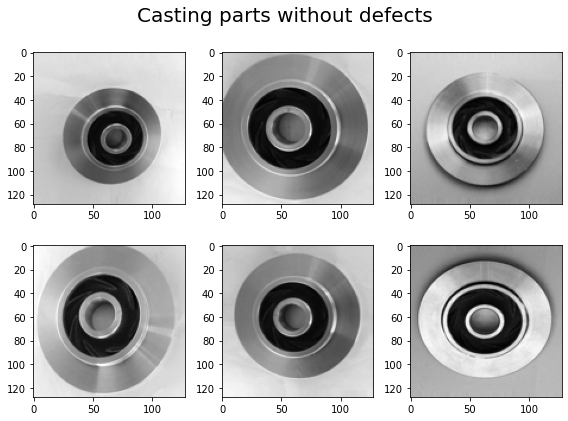

In [7]:
fig, axes = pyplot.subplots(2, 3, figsize=(8, 6), tight_layout=True)
axes[0, 0].imshow(ok_images[0].reshape((res, res)), cmap="gray")
axes[0, 1].imshow(ok_images[50].reshape((res, res)), cmap="gray")
axes[0, 2].imshow(ok_images[100].reshape((res, res)), cmap="gray")
axes[1, 0].imshow(ok_images[150].reshape((res, res)), cmap="gray")
axes[1, 1].imshow(ok_images[200].reshape((res, res)), cmap="gray")
axes[1, 2].imshow(ok_images[250].reshape((res, res)), cmap="gray")
fig.suptitle("Casting parts without defects", fontsize=20);

And some images of the casting parts with defects:

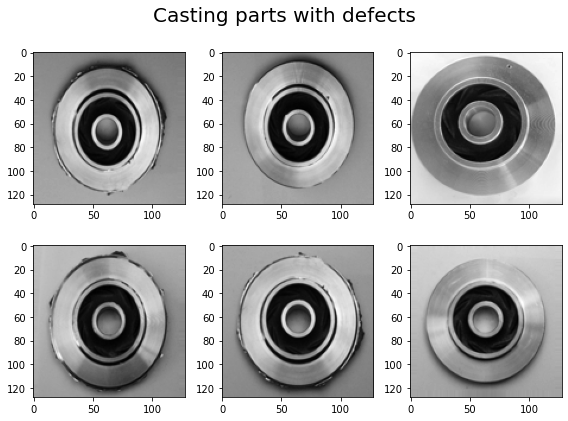

In [8]:
fig, axes = pyplot.subplots(2, 3, figsize=(8, 6), tight_layout=True)
axes[0, 0].imshow(def_images[0].reshape((res, res)), cmap="gray")
axes[0, 1].imshow(def_images[50].reshape((res, res)), cmap="gray")
axes[0, 2].imshow(def_images[100].reshape((res, res)), cmap="gray")
axes[1, 0].imshow(def_images[150].reshape((res, res)), cmap="gray")
axes[1, 1].imshow(def_images[200].reshape((res, res)), cmap="gray")
axes[1, 2].imshow(def_images[250].reshape((res, res)), cmap="gray")
fig.suptitle("Casting parts with defects", fontsize=20);

## Multiple logistic regression

Lesson 2 introduced you to logistic regression for binary classification based on a single feature. A logistic regression model can also be used to predict the probability of a multi-dimensional input (e.g., an image) being of class $1$ or $0$.

The numbers $1$ and $0$ represent digitized labels, classes, or categories. Humans naturally use strings to label or categorize things. Computationally, it is easier to use numbers to describe categories. In this lesson, we will use $1$ to represent defective casting parts and $0$ for normal parts. Our logistic model aims to predict the probability of a casting part being defective.

The only difference between this lesson and lesson 2 is the number of input features. You have seen multiple linear regression in lesson 3: the setting is similar here. If we have $N$ images during training, our model is:

$$
\begin{aligned}
\hat{y}^{(1)} &= \operatorname{logistic}\left(b + w_1 x_1^{(1)} + w_2 x_2^{(1)} + \cdots + w_{n} x_{n}^{(1)}\right) \\
\hat{y}^{(2)} &= \operatorname{logistic}\left(b + w_1 x_1^{(2)} + w_2 x_2^{(2)} + \cdots + w_{n} x_{n}^{(2)}\right) \\
\vdots & \\
\hat{y}^{(N)} &= \operatorname{logistic}\left(b + w_1 x_1^{(N)} + w_2 x_2^{(N)} + \cdots + w_{n} x_{n}^{(N)}\right) \\
\end{aligned}
$$

where the superscripts $(1)\dots(N)$ denote the $N$ images; $\hat{y}$ is the predicted probability of the corresponding image being defective; and $x_1, x_2, \dots, x_{n}$ represent the greyscale values for the $n$ pixels.

In matrix-vector form:

$$
\begin{bmatrix}\hat{y}^{(1)} \\ \vdots \\ \hat{y}^{(N)}\end{bmatrix} =
\operatorname{logistic}\left(
\begin{bmatrix}b \\ \vdots \\ b \end{bmatrix} + 
\begin{bmatrix}
x_1^{(1)} & \cdots & x_{n}^{(1)} \\
\vdots & \ddots & \vdots \\
x_1^{(N)} & \cdots & x_{n}^{(N)}
\end{bmatrix}
\begin{bmatrix}w_1 \\ \vdots \\ w_{n} \end{bmatrix}
\right)
$$

<br />

$$
\mathbf{\hat{y}}  = 
\operatorname{logistic}\left(\mathbf{b} + X \mathbf{w}\right)
$$

The code for the logistic function is the same as in lesson 2, but now it also works with an array input.

In [9]:
def logistic(x):
    """Logistic/sigmoid function.
    
    Arguments
    ---------
    x : numpy.ndarray
        The input to the logistic function.
    
    Returns
    -------
    numpy.ndarray
        The output.
        
    Notes
    -----
    The function does not restrict the shape of the input array. The output
    has the same shape as the input.
    """
    return 1. / (1. + numpy.exp(-x))

And our multiple logistic regression model:

In [10]:
def logistic_model(x, params):
    """A logistic regression model.
    
    A a logistic regression is y = sigmoid(x * w + b), where the operator *
    denotes a mat-vec multiplication.
    
    Arguments
    ---------
    x : numpy.ndarray
        The input of the model. The shape should be (n_images, n_total_pixels).
    params : a tuple/list of two elemets
        The first element is a 1D array with shape (n_total_pixels). The
        second element is a scalar (the intercept)

    Returns
    -------
    probabilities : numpy.ndarray
        The output is a 1D array with length n_samples.
    """
    return logistic(numpy.dot(x, params[0]) + params[1])

The loss function is also the same as in lesson 2:
$$
L = - \frac{1}{N} \sum_{i=1}^{N} y_{\text{true}}^{(i)}\log\left(\hat{y}^{(i)}\right) + \left(1-y_{\text{true}}^{(i)}\right)\log\left(1-\hat{y}^{(i)}\right)
$$

Or, in vector form:

$$
L = - \frac{1}{N} \left[
\mathbf{y}_{\text{true}}\cdot\log\left(\mathbf{\hat{y}}\right)+
\left(\mathbf{1}-\mathbf{y}_{\text{true}}\right)\cdot\log\left(\mathbf{1}-\mathbf{\hat{y}}\right)\
\right]
$$

where the bolded $\mathbf{1}$ represents a vector of ones.

In [11]:
def model_loss(x, true_labels, params):
    """Calculate the predictions and the loss w.r.t. the true values.
    
    Arguments
    ---------
    x : numpy.ndarray
        The input of the model. The shape should be (n_images, n_total_pixels).
    true_labels : numpy.ndarray
        The true labels of the input images. Should be 1D and have length of
        n_images.
    params : a tuple/list of two elements
        The first element is a 1D array with shape (n_total_pixels). The
        second elenment is a scalar.
    
    Returns
    -------
    loss : a scalar
        The summed loss.
    """
    pred = logistic_model(x, params)
    
    n_images = x.shape[0]
    
    loss = - (
        numpy.dot(true_labels, numpy.log(pred+1e-15)) +
        numpy.dot(1.-true_labels, numpy.log(1.-pred+1e-15))
    ) / n_images
    
    return loss

To avoid overfitting, we add regularization to the loss, which was introduced in lesson 4:

$$
L^{reg} = L + \frac{\lambda}{n}\sum_{i=1}^{n}{w_i}^2
$$

In [12]:
def regularized_loss(x, true_labels, params, _lambda=1.):
    """Return the loss with regularization.
    
    Arguments
    ---------
    x, true_labels, params :
        Parameters for function `model_loss`.
    _lambda : float
        The weight of the regularization term. Default: 1.0
    
    Returns
    -------
    loss : a scalar
        The summed loss.
    """
    loss = model_loss(x, true_labels, params) 
    return loss + _lambda * numpy.mean(params[0]**2)

Compared to the equation in lesson 4, we have an extra $\frac{1}{n}$ in the weight of the regularization term. We do this to keep $\lambda=1$ but still have the magnitude of the regularization term comparable to the original loss $L$. $\frac{1}{n}$ can be absorbed into $\lambda$ if you want -- $\lambda$ is a hyperparameter that you can tune and freely choose the value.

##### Notes:

1. We added a tiny term `1e-15` to the `log` calculation to avoid the infinity when `pred` or/and `1-pred` are zero.
2. Why don't we combine `model_loss` and `regularized_loss`? When tracking the history of losses during optimization, we may need original losses (i.e., non-regularized), so we need a function to give us non-regularized losses.
3. The functions `model_loss` and `regularized_loss` combine the calculations of model predictions and the loss. By doing so, we can easily calculate the gradients using the `grad` from `autograd`, just like we did in lesson 2.

## Training, validation, and test datasets

The goal of a machine learning model is to predict something that it never sees during training. For this reason, we should evaluate the performance (e.g., accuracy) of a machine learning model against data that are not part of training. The data, however, should be similar to the training data.

Model optimization (i.e., model fitting) is referred to as _training_ the model in analogy to teaching humans. In school, students practice with take-home exercises. Throughout the semester, you have quizzes to monitor your learning progress. And at the end of the semester, teachers evaluate your performance using final exams. The problems in quizzes and final exams are different from take-home exercises but similar enough. A well-trained student should be able to solve them using the knowledge learned from take-home exercises.

Training a machine learning model is similar. We split our data into three datasets: **training**, **validation**, and **test** datasets. We use the training dataset to train the model and monitor the learning progress using the validation dataset during the training. At the end of the training, we use the test dataset to evaluate the model's final performance.

Updating the model parameters using gradient descent only requires the training dataset. Every several optimization iterations, we can evaluate the current performance using the validation dataset and adjust the training strategy in real-time accordingly. This adjustment is called **hyperparameter tuning**. We will talk about hyperparameter tuning in later lessons. On the other hand, if the training progress is satisfying and reaches our performance goal, we can stop the optimization iterations earlier.

We have no rigorous theory for how big the training, validation, and test datasets should be. Nevertheless, for a dataset as small as what we have in this lesson (i.e., 1300 images), a typical split is 60% for training, 20% for validation, and the remaining 20% for testing.

The code below splits the data with these proportions.

In [13]:
# numbers of images for validation (~ 20%)
n_ok_val = int(n_ok_total * 0.2)
n_def_val = int(n_def_total * 0.2)
print("Number of images without defects in validation dataset:", n_ok_val)
print("Number of images with defects in validation dataset:", n_def_val)

# numbers of images for test (~ 20%)
n_ok_test = int(n_ok_total * 0.2)
n_def_test = int(n_def_total * 0.2)
print("Number of images without defects in test dataset:", n_ok_test)
print("Number of images with defects in test dataset:", n_def_test)

# remaining images for training (~ 60%)
n_ok_train = n_ok_total - n_ok_val - n_ok_test
n_def_train = n_def_total - n_def_val - n_def_test
print("Number of images without defects in training dataset:", n_ok_train)
print("Number of images with defects in training dataset:", n_def_train)

Number of images without defects in validation dataset: 103
Number of images with defects in validation dataset: 156
Number of images without defects in test dataset: 103
Number of images with defects in test dataset: 156
Number of images without defects in training dataset: 313
Number of images with defects in training dataset: 469


After determining the numbers of images in the three datasets, we use [`numpy.split()`](https://numpy.org/doc/stable/reference/generated/numpy.split.html) to do the splitting. Be sure to reaad the documentation for this handy function.

In [14]:
ok_images = numpy.split(ok_images, [n_ok_val, n_ok_val+n_ok_test], 0)
def_images = numpy.split(def_images, [n_def_val, n_def_val+n_def_test], 0)

The final step is to combine the images with and without defects. We use `numpy.concatenate`.

In [15]:
images_val = numpy.concatenate([ok_images[0], def_images[0]], 0)
images_test = numpy.concatenate([ok_images[1], def_images[1]], 0)
images_train = numpy.concatenate([ok_images[2], def_images[2]], 0)

You can use `pyplot.imshow` to visualize the images in these three datasets, just like we did previously. 

## Data normalization: z-score normalization

In lesson 3, you learned about data normalization and a technique called min-max scaling. Here, we introduce an alternative method called **z-score normalization**:

$$
z = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

Here, $\mu_{\text{train}}$ and $\sigma_{\text{train}}$ denote the mean value and the standard deviation of the training dataset. Remember that no matter whether $x$ represents training, validation, or test datasets, we always have to use the mean value and the standard deviation from the _training_ dataset.

In [16]:
# calculate mu and sigma
mu = numpy.mean(images_train, axis=0)
sigma = numpy.std(images_train, axis=0)

# normalize the training, validation, and test datasets
images_train = (images_train - mu) / sigma
images_val = (images_val - mu) / sigma
images_test = (images_test - mu) / sigma

##### Notes:

1. $\mu_{\text{train}}$ and $\sigma_{\text{train}}$ are the mean and the standard deviation of pixels across different images. So the shape of `mu` and `sigma` should be the same as the image resolution, which is `(128, 128)` for this particular dataset.
2. After the z-score normalization, the resulting training dataset has mean value of $0$ and standard deviation of $1$ for all pixels.
3. We normalize the validation and test datasets with the training dataset's mean and standard deviation. However, normalized validation and test datasets should have mean and standard deviation close to 0 and 1 because validation and test data should be similar to training data.

## Creating labels/classes

We now have images as input data to train a model. We will need to provide the correct labels for these images, corresponding to defective and normal parts. It's analogous to your teacher giving you the solutions to take-home exercises, for you to practice.

To label the images, we use $1$ to represent defective parts, and $0$ for normal parts. The code below creates `labels_train`, `labels_val`, and `labels_test`, which hold the labels for the images in training, validation, and test datasets.

In [17]:
# labels for training data
labels_train = numpy.zeros(n_ok_train+n_def_train)
labels_train[n_ok_train:] = 1.

# labels for validation data
labels_val = numpy.zeros(n_ok_val+n_def_val)
labels_val[n_ok_val:] = 1.

# labels for test data
labels_test = numpy.zeros(n_ok_test+n_def_test)
labels_test[n_ok_test:] = 1.

Also, recall that a logistic model only predicts a casting part's probability of having defects. We need to set a decision threshold and say that if a probability is higher than this threshold, the corresponding casting part is defective. Like in lesson 2, we use $0.5$ for the threshold here:

In [18]:
def classify(x, params):
    """Use a logistic model to label data with 0 or/and 1.
    
    Arguments
    ---------
    x : numpy.ndarray
        The input of the model. The shape should be (n_images, n_total_pixels).
    params : a tuple/list of two elements
        The first element is a 1D array with shape (n_total_pixels). The
        second element is a scalar.
    
    Returns
    -------
    labels : numpy.ndarray
        The shape of the label is the same with `probability`.
    
    Notes
    -----
    This function only works with multiple images, i.e., x has a shape of
    (n_images, n_total_pixels).
    """
    probabilities = logistic_model(x, params)
    labels = (probabilities >= 0.5).astype(float)
    return labels

## Evaluating model performance: F-score

Before we train our model, we need to define some metrics to evaluate the performance against the validation data _during_ training. We consider four possible outcomes of the prediction results:

1. **True-positive (TP)**: the model predicts that a part has defects, and it does.
2. **False-positive (FP)**: the model predicts that a part has defects, but it does not.
3. **True-negative (TN)**: the model predicts that a part does not have defects, and it does not.
4. **False-negative (FN)**: the model predicts that a part does not have defects, but it does.

A table called a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix) or **error matrix** summarizes the four outcomes:

|                           | w/ defects (predicted) | w/o defects (predicted) |
|---------------------------|------------------------|-------------------------|
| w/ defects (true answer)  | $N_{TP}$               | $N_{FN}$                |
| w/o defects (true answer) | $N_{FP}$               | $N_{TN}$                |

$N_{TP}$, $N_{FP}$, $N_{FN}$, and $N_{TN}$ denote the numbers of images with each of the four outcomes.

Using an error matrix, we can define several metrics to evaluate the performance; the most basic ones are **precision** and **recall**.
Precision measures how many parts actually have defects among those predicted to be defective. Recall means how many defective parts are actually caught by the model.

$$
\mathrm{precision}\equiv\frac{\text{number of defective parts identified by the model}}{\text{predicted total number of defective parts}} = \frac{N_{TP}}{N_{TP}+N_{FP}}
$$

$$
\mathrm{recall}\equiv\frac{\text{number of defective parts identified by the model}}{\text{total number of defective parts}} = \frac{N_{TP}}{N_{TP}+N_{FN}}
$$

The two metrics together measure the model performance.
For example, a model with low precision but high recall successfully catches most defective parts, but also misjudges many normal parts. This causes many normal parts to be discarded and increases the cost of manufacturing.

Using a single number to evaluate the performance is desirable, and thus we define the **F-score** as a metric combining both precision and recall into one single value:

$$
\text{F-score}\equiv\frac{\left(1+\beta^2\right)\mathrm{precision}\times\mathrm{recall}}{\beta^2 \mathrm{precision} + \mathrm{recall}}
$$

$\beta$ is a user-defined coefficient representing the weight of recall. A higher $\beta$ means recall is more important than precision, and vice versa. When $\beta=1$, we don't have any preference over precision or recall. Let's pick that for this lesson.

In [19]:
def performance(predictions, answers, beta=1.0):
    """Calculate precision, recall, and F-score.
    
    Arguments
    ---------
    predictions : numpy.ndarray of integers
        The predicted labels.
    answers : numpy.ndarray of integers
        The true labels.
    beta : float
        A coefficient representing the weight of recall.
    
    Returns
    -------
    precision, recall, score : float
        Precision, recall, and F-score, respectively.
    """
    true_idx = (answers == 1)  # the location where the answers are 1
    false_idx = (answers == 0)  # the location where the answers are 0
    
    # true positive: answers are 1 and predictions are also 1
    n_tp = numpy.count_nonzero(predictions[true_idx] == 1)
    
    # false positive: answers are 0 but predictions are 1
    n_fp = numpy.count_nonzero(predictions[false_idx] == 1)
    
    # true negative: answers are 0 and predictions are also 0
    n_tn = numpy.count_nonzero(predictions[false_idx] == 0)
    
    # false negative: answers are 1 but predictions are 0
    n_fn = numpy.count_nonzero(predictions[true_idx] == 0)
    
    # precision, recall, and f-score
    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    score = (
        (1.0 + beta**2) * precision * recall / 
        (beta**2 * precision + recall)
    )

    return precision, recall, score

A higher F-score is better. A perfect model has F-score of one (or $100\%$) regardless of $\beta$, which means both precision and recall are $100\%$. 

## Initialization

Let's initialize the parameters to zero, and use `grad` to compute derivatives with respect to the parameters, as before:

In [20]:
# a function to get the gradients of a logistic model
gradients = grad(regularized_loss, argnum=2)

# initialize parameters
w = numpy.zeros(images_train.shape[1], dtype=float)
b = 0.

Before training, we calculate the initial F-score against the test dataset to see how much the prediction improves after training.

In [21]:
# initial accuracy
pred_labels_test = classify(images_test, (w, b))
perf = performance(pred_labels_test, labels_test)

print("Initial precision: {:.1f}%".format(perf[0]*100))
print("Initial recall: {:.1f}%".format(perf[1]*100))
print("Initial F-score: {:.1f}%".format(perf[2]*100))

Initial precision: 60.2%
Initial recall: 100.0%
Initial F-score: 75.2%


You may be surprised at the not-so-bad initial performance. In fact, this initial performance is skewed by the improper design of the datasets.

Due to the all-zero initial parameters, the model initially predicts that all parts have defects. In other words, the variable `pred_labels_test` is an array of ones. Now, remember that we have 103 normal parts and 156 defective parts in our test dataset. With an initial prediction of all parts being defective, we have the following error matrix:

|                           | w/ defects (predicted) | w/o defects (predicted) |
|---------------------------|------------------------|-------------------------|
| w/ defects (true answer)  | $N_{TP}=156$           | $N_{FN}=0$              |
| w/o defects (true answer) | $N_{FP}=103$           | $N_{TN}=0$              |

The initial precision is about $60.2\%$, and the initial recall is exactly $100\%$. The initial F-score is $75.2\%$.

The high initial performance comes from having more defective parts than normal parts in the test dataset. Designing a proper ratio between data labeled with 1 and 0 is therefore critical. It's like designing and answering true-false questions of an exam. If the correct answers to a set of true-false questions are mostly true, and a lazy student guesses true for all questions and finishes the quiz in one minute, they can get a very high score! Yet that score does not truly represent the student's knowledge level.

In machine learning, test and validation data should mimic real-world data. For example, if 98% of production from a casting factory meets the quality criterion, using a test dataset with 156 defective and 103 normal parts may be improper.

In this lesson, we will leave the datasets as-is. Designing a good dataset is application-dependent: it requires deep knowledge and experience in the corresponding field of application.

## Training/optimization

In the optimization loop (using gradient descent), we'll monitor the progress of training using the validation dataset. If the validation loss is not changing much, we'll stop the training. The loss we want to monitor is the original loss. On the other hand, when calculating the gradients, we use the regularized loss against the training data.

Here, we only use validation loss to control the optimization. In real applications, it's common to use a combination of validation loss, accuracy, and other metrics to control the optimization.

Also, the step size (the variable `lr`) is `1e-2`. The step size affects whether we can and how fast we'll find the solution. Finding a proper step size requires hyperparameter tuning mentioned previously. Here we just give you a proper value we found as hyperparameter tuning is out of the scope of this lesson.

In [22]:
%%time

# step size
lr = 1e-2

# a variable for the change in validation loss
change = numpy.inf

# a counter for optimization iterations
i = 0

# a variable to store the validation loss from the previous iteration
old_val_loss = 1e-15

# keep running if:
#   1. we still see significant changes in validation loss
#   2. iteration counter < 10000
while change >= 1e-6 and i < 10000:
    
    # calculate gradients and use gradient descents
    grads = gradients(images_train, labels_train, (w, b))
    w -= (grads[0] * lr)
    b -= (grads[1] * lr)
    
    # validation loss
    val_loss = model_loss(images_val, labels_val, (w, b))
    
    # calculate f-scores against the validation dataset
    pred_labels_val = classify(images_val, (w, b))
    score = performance(pred_labels_val, labels_val)

    # calculate the chage in validation loss
    change = numpy.abs((val_loss-old_val_loss)/old_val_loss)

    # update the counter and old_val_loss
    i += 1
    old_val_loss = val_loss
    
    # print the progress every 10 steps
    if i % 10 == 0:
        print("{}...".format(i), end="")

10...20...30...40...50...60...70...80...90...100...110...120...130...140...150...160...170...180...190...200...210...220...230...240...250...260...270...280...290...300...310...320...330...340...350...360...370...380...390...400...410...420...430...440...450...460...470...480...490...500...510...520...530...540...550...560...570...580...590...600...610...620...630...640...650...660...CPU times: user 34.2 s, sys: 412 ms, total: 34.6 s
Wall time: 5.77 s


In [23]:
val_loss_reg = regularized_loss(images_train, labels_train, (w, b))

print("")
print("")
print("Upon optimization stopped:")
print("    Iterations:", i)
print("    Validation loss w/o regularization:", val_loss)
print("    Validation loss w/ regularization:", val_loss_reg)
print("    Validation precision:", score[0])
print("    Validation recall:", score[1])
print("    Validation F-score:", score[2])
print("    Change in validation loss:", change)



Upon optimization stopped:
    Iterations: 666
    Validation loss w/o regularization: 0.5188273788049017
    Validation loss w/ regularization: 0.04127987992406643
    Validation precision: 0.8951048951048951
    Validation recall: 0.8205128205128205
    Validation F-score: 0.8561872909698997
    Change in validation loss: 9.484651848988673e-07


We didn't use the validation F-score to stop the optimization because improving the predicted probability does not necessarily improve the predicted labels. For example, suppose the probabilities predicted by the logistic model during the last three iterations are $0.1$, $0.2$, and $0.3$. In that case, the predicted labels are still $0$, $0$, and $0$ for the three iterations. Hence monitoring F-score (which relies on predicted labels) will cause the optimization to stop too early while the model is still improving.

Finally, let's examine the model's performance using the test dataset and see if it's better than the initial performance.

In [24]:
# final accuracy
pred_labels_test = classify(images_test, (w, b))
perf = performance(pred_labels_test, labels_test)

print("Final precision: {:.1f}%".format(perf[0]*100))
print("Final recall: {:.1f}%".format(perf[1]*100))
print("Final F-score: {:.1f}%".format(perf[2]*100))

Final precision: 88.6%
Final recall: 84.6%
Final F-score: 86.6%


Bravo! The precision improved from $60.2\%$ to $88.6\%$, which means when our model says a part has defects, there is an $88.6\%$ chance it is indeed defective. The recall dropped from $100%$ to $84.6\%$, which means our model misses about $15\%$ of the defective parts. The F-score, representing overall accuracy, improved from $75.2\%$ to $86.6\%$.

##### Final note

No model is perfect, and it's not realistic to expect $100\%$ accuracy. How accurate a model should be to consider it a good model is problem-dependent. Still, an F-score of $86.6\%$ does not seem very exciting. And it's not pleasant to see about $15\%$ of defective products slip through and may be handed over to customers. 

In a later lesson, we will improve the performance by replacing the multiple logistic regression model with something more interesting: a **neural network** model.

## What we've learned

- Turn an image into a vector of grayscale values to use it as input data.
- Set up a classification problem from multi-dimensional feature vectors.
- Apply multiple logistic regression to identify defective metal-casting parts.
- Split data into training, validation, and test datasets to assess model performance.
- Normalize the data using z-score.
- Evaluate the performance of a classification model using F-score.

## Reference

1. Kantesaria, N., Vaghasia, P., Hirpara, J., & Bhoraniya, R., (2020). Casting product image data for quality inspection. Kaggle. https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product

In [25]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())